# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

### Solution

In [1]:
import pandas as pd
# Import plotting modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Set default Seaborn style
sns.set()

#import dataset
df = pd.read_csv('human_body_temperature.csv')

In [2]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [4]:
## Function definitions. These functions will be used in subsequent cells

#Plot numerical features as ECDF (Empirical cumulative distribution function) curves to see their distribution in the dataset
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)
    return bs_replicates

def diff_from_population_mean(data, population_mean=98.6):
    return np.mean(data) - population_mean

def percentile_95_lower(data):
    return np.percentile(data,[2.5])

def percentile_95_upper(data):
    return np.percentile(data,[97.5])

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)
    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

### 1. Is the distribution of body temperatures normal?

In [5]:
sample_mean=np.mean(df['temperature'])
sample_std=np.std(df['temperature'])

In [6]:
print('Sample Mean =',sample_mean,' Sample Standard Deviation =',sample_std)

Sample Mean = 98.24923076923075  Sample Standard Deviation = 0.730357778905038


In [7]:
Max_Std = (np.max(df['temperature']) - sample_mean)/sample_std
Min_Std = (sample_mean - np.min(df['temperature']))/sample_std
if Max_Std >= Min_Std:
    print('Maximum number of standard deviations within data is ',Max_Std)
else:
    print('Maximum number of standard deviations within data is ',Min_Std)

Maximum number of standard deviations within data is  3.4924927267748074


In [8]:
simulated_samples = np.random.normal(sample_mean,sample_std,100000)

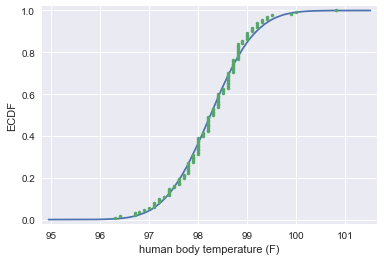

In [9]:
x,y = ecdf(df['temperature'])
x_theor,y_theor = ecdf(simulated_samples)

# Overlay the plots
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
# Margins and axis labels
plt.margins(.02)
plt.xlabel('human body temperature (F)')
plt.ylabel('ECDF')
# Show the plot
plt.show()

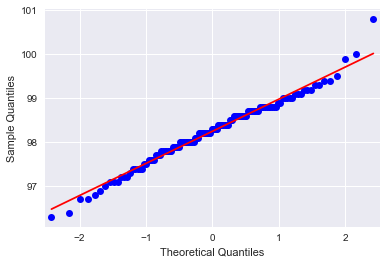

In [10]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df['temperature'], line='s')
plt.show()

#### The plots above suggests that the sample is normally distributed.

In [11]:
# normality test
from scipy.stats import shapiro
stat, p = shapiro(df['temperature'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Normally distributed  (fail to reject H0)')
else:
    print('Sample does not look Normally distributed (reject H0)')

Statistics=0.987, p=0.233
Sample looks Normally distributed  (fail to reject H0)


### 2. Is the sample size large? Are the observations independent?
* Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.

### 3. Is the true population mean really 98.6 degrees F?
* First, try a bootstrap hypothesis test.
* Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
* In this situation, is it appropriate to use the  tt  or  zz  statistic?
* Now try using the other test. How is the result be different? Why?

In [12]:
# bootstrap hypothesis test
# Null hypothesis: H0 = The true mean of temperatures was 98.6
# alpha = 0.05
# Test statistic = mean
sample_diff = diff_from_population_mean(df['temperature'])
data_shifted = df['temperature'] - np.mean(df['temperature']) + 98.6
bootstrat_replicates = draw_bs_reps(data_shifted,diff_from_population_mean,size=100000)
p = np.sum(bootstrat_replicates <= sample_diff) /len(bootstrat_replicates)
print('p-value:',p)

p-value: 0.0


* The extremely low p-value suggests that the null hypothesis can be rejected. The population mean is not 98.6

In [13]:
#Frequentist statistical test. We use one sample ttest
from scipy import stats
# Null hypothesis: H0 = The true mean of temperatures was 98.6. Alpha=0.05
stats.ttest_1samp(df['temperature'],98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

* The extremely low p-value suggests that the null hypothesis can be rejected. The true population mean is not 98.6
* One sample t test is more appropriate in this case, since we don’t know the population standard deviation 
* tt statistic is more appropriate in this case, as we dont know population standard deviation. 

In [14]:
# z test
from statsmodels.stats import weightstats as stests
stests.ztest(df['temperature'], value=98.6)

(-5.4548232923645195, 4.9021570141012155e-08)

* The extremely low p-value suggests that the null hypothesis can be rejected. The true population mean is not 98.6

In [15]:
bootstrat_replicates = draw_bs_reps(df['temperature'],np.mean,size=100000)
print('The average human body temperature is',np.mean(bootstrat_replicates))

The average human body temperature is 98.24907799999998


### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.
* Which one is the correct one to use?
* What do you notice? What does this tell you about the difference in application of the  tt  and  zz  statistic?

In [16]:
inds = np.arange(10)
np.random.seed(42)
random_inds = np.random.choice(inds, size=len(inds))
small_sample_10 = df['temperature'][random_inds]

In [17]:
# Null hypothesis: H0 = The true mean of temperatures was 98.6. Alpha=0.05
stats.ttest_1samp(small_sample_10,98.6)

Ttest_1sampResult(statistic=-1.8347785189881873, pvalue=0.0997357600099643)

In [18]:
# Null hypothesis: H0 = The true mean of temperatures was 98.6. Alpha=0.05
stests.ztest(small_sample_10, value=98.6)

(-1.8347785189881873, 0.06653851267762154)

* The p-values from tests on the smaller sample suggest that there is enough evidence to not to reject the null hypothesis

### 5. At what temperature should we consider someone's temperature to be "abnormal"?
* As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
* Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

In [19]:
bootstrat_replicates_lower = draw_bs_reps(df['temperature'],percentile_95_lower,size=100000)
bootstrat_replicates_upper = draw_bs_reps(df['temperature'],percentile_95_upper,size=100000)
confidence_interval_lower,confidence_interval_upper = np.mean(bootstrat_replicates_lower), np.mean(bootstrat_replicates_upper)
print('There is a 95% chance that 95% of the temperatures will be within the range:', confidence_interval_lower
      ,confidence_interval_upper)

There is a 95% chance that 95% of the temperatures will be within the range: 96.76778642500003 99.58047647500001


In [20]:
stats.norm.interval(0.95, loc=np.mean(df['temperature']), scale=np.std(df['temperature']))

(96.81775582674821, 99.68070571171329)

* Human tempearure will be considered abnormal if it is below 96.8 or above 99.6 

### 6. Is there a significant difference between males and females in normal temperature?
* What testing approach did you use and why?
* Write a story with your conclusion in the context of the original problem.

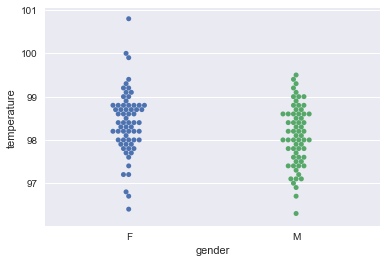

In [21]:
# Create bee swarm plot with Seaborn's default settings
_ = sns.swarmplot(x='gender', y='temperature', data=df)
# Label the axes
_ = plt.xlabel('gender')
_ = plt.ylabel('temperature')
# Show the plot
plt.show()

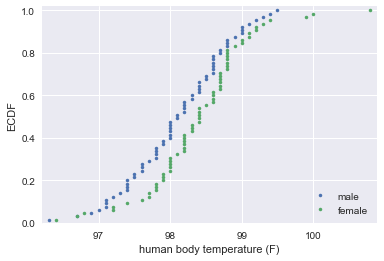

In [22]:
# Plot ECDF for male and female temperature:
x_tempm, y_tempm = ecdf(df[df.gender=='M']['temperature'])
x_tempf, y_tempf = ecdf(df[df.gender=='F']['temperature'])
# Generate plot
_ = plt.plot(x_tempm, y_tempm,marker='.',linestyle='none')
_ = plt.plot(x_tempf, y_tempf,marker='.',linestyle='none')
# Make the margins nice
_ = plt.margins(.02)
# Label the axes
plt.xlabel('human body temperature (F)')
plt.ylabel('ECDF')
plt.legend(('male', 'female'), loc='lower right')
# Display the plot
plt.show()

* The plots above suggests that there is difference between male and female body temperatures.

In [23]:
temp_male = df[df.gender=='M']['temperature']
temp_female = df[df.gender=='F']['temperature']

print('Sample mean body temperature of female & male are',np.mean(temp_female),np.mean(temp_male),'respectively')

Sample mean body temperature of female & male are 98.39384615384614 98.10461538461537 respectively


In [24]:
#Null hypothesis: The probability distributions of both female & male temperatures are identical
# test statistic is difference of means
# alpha = 0.05
# Compute observed difference of means between female and male temperatures
empirical_diff_means = diff_of_means(temp_female, temp_male)
# Draw 100,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(temp_female, temp_male, diff_of_means, size=100000)
# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
# Print the result
print('p-value =', p)

p-value = 0.01175


* P-value is less than alpha. So we reject the Null hypothesis that female & male temperatures are identically distributed. 
* Here, we used a permutation sample test, as we have both sets of data points (female temperature & male temperature).

In [25]:
bootstrat_replicates_male = draw_bs_reps(temp_male,np.mean,size=100000)
print('The average male human body temperature is',np.mean(bootstrat_replicates_male))
bootstrat_replicates_female = draw_bs_reps(temp_female,np.mean,size=100000)
print('The average female human body temperature is',np.mean(bootstrat_replicates_female))

The average male human body temperature is 98.10517736923079
The average female human body temperature is 98.39416932307694


#### Conclusion:
* The dataset contains 130 observations of both male and female body temperatures and heart rates. 
* It is safe to assume that the body temperature in this sample dataset is normally distributed. 
* Contrary to commonly held belief, the average human body tempeature is not 98.6F. It is around 98.25F
* We have also found that the average male body temperature is around 98.1F and that of female is around 98.4F
* So, there is a difference between male and female body temperatures